In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score,auc,roc_curve
from sklearn.preprocessing import LabelBinarizer,StandardScaler

from sklearn import model_selection as cv
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from dbn.tensorflow import SupervisedDBNClassification
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from tensorflow.keras.layers import Input,Dense,LSTM,GRU,BatchNormalization
from tensorflow.keras.layers import PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as K
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [4]:
df = pd.read_csv('./dataset/joint/2.storke_combine_code_multi_balance.csv')

In [5]:
Y = np.array(df.pop('NIHSS'))
X = np.array(df)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y,random_state = 3)

In [7]:
Class = [0,1,2]
Class_dict = dict(zip(Class, range(len(Class))))
Class_dict
lb = LabelBinarizer()
lb.fit(list(Class_dict.values()))
y_train_labels = lb.transform(y_train)

In [8]:
x_train_lstm = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_lstm = x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [9]:
class PUSE(object):
    def __init__(self, n, narvs, k, x_lb, x_ub):
        self.n = n #恒星数量
        self.narvs = narvs #宇宙的维度
        self.x_lb = x_lb  # 宇宙的边界
        self.x_ub = x_ub # 宇宙的边界
        self.k = k # 膨胀的次数（时间）
        
        self.explore1 = 2 # 个体恒星的膨胀因子
        self.explore2 = 2 # 所有恒星的膨胀因子
        self.w_start = 5 # 恒星的冲击波
        self.w_end = 1 # 恒星的冲击波
        self.volumemax = 6 #最大爆炸能量

        
        self.x1 = [] #经度
        self.x2 = [] #维度
        self.e1 = []
        self.e2 = []
        self.fit = np.zeros((n,1))
                
        self.init_Star()
        
        self.x1 = np.array(self.x1).astype('int64')
        self.x2 = np.array(self.x2).astype('int64')
        
        self.init_Energy()
        
        
        self.xbest = []
        self.prexbest = []

        self.init_MAXenergy()
        
        
 
    def init_Star(self):
        m1 = np.zeros((self.n,1))
        m2 = np.zeros((self.n,1))
        n1 = np.zeros((self.n,1))
        n2 = np.zeros((self.n,1))
        
        m1[0]=0.7      
        for i in range(1,self.n):
            k = i-1
            m1[i] = 2.3*((m1[k])**2)*math.sin(math.pi*m1[k])
        m2[0]=m1[self.n-1]
        for i in range(1,self.n):
            k = i-1
            m2[i] = 2.3*((m2[k])**2)*math.sin(math.pi*m2[k])
            
        for i in range(self.n):        
            n1[i] = int(np.ceil(m1[i]*(self.x_lb-self.x_lb))+self.x_lb) 
            n2[i] = int(np.ceil(m2[i]*(self.x_lb-self.x_lb))+self.x_lb)
            self.x1.append(n1[i])
            self.x2.append(n2[i])
        self.e1 = [int(np.ceil(np.random.rand()*(2*self.volumemax)))-self.volumemax for i in range(self.n)]
        self.e2 = [int(np.ceil(np.random.rand()*(2*self.volumemax)))-self.volumemax for i in range(self.n)]
        
    def init_Energy(self):
        for i in range(self.n):
            self.fit[i] = func(self.x1[i],self.x2[i])
    
    def init_MAXenergy(self):
        fitbest = min(self.fit)
        indbest = self.fit.tolist().index(fitbest)
        self.xbest.append(self.x1[indbest])
        self.xbest.append(self.x2[indbest])
        self.prexbest = self.xbest

    def iterator(self):       
        for d in range(self.k):
            for i in range(self.n):
                w = int(np.ceil(self.w_start - (self.w_start-self.w_end)*d/self.k))
                self.e1[i] = int(np.ceil(w*self.e1[i] + self.explore1*np.random.rand()*(self.prexbest[0]-self.x1[i]) + self.explore2*np.random.rand()*(self.xbest[0]-self.x1[i])))
                self.e2[i] = int(np.ceil(w*self.e2[i] + self.explore1*np.random.rand()*(self.prexbest[1]-self.x2[i]) + self.explore2*np.random.rand()*(self.xbest[1]-self.x2[i])))
                for j in range(self.n):
                    if self.e1[j] < -self.volumemax:
                        self.e1[j] = -self.volumemax
                    elif self.e1[j] > self.volumemax:
                        self.e1[j] = self.volumemax
                    if self.e2[j] < -self.volumemax:
                        self.e2[j] = -self.volumemax
                    elif self.e2[j] > self.volumemax:
                        self.e2[j] = self.volumemax
                self.x1[i] = self.x1[i] + self.e1[i]
                self.x2[i] = self.x2[i] + self.e2[i]
                for j in range(self.n):
                    if self.x1[j] < self.x_lb:
                        self.x1[j] = self.x_lb
                    elif self.x1[j] > self.x_ub-1:
                        self.x1[j] = self.x_ub-1
                    if self.x2[j] < self.x_lb:
                        self.x2[j] = self.x_lb
                    elif self.x2[j] > self.x_ub-1:
                        self.x2[j] = self.x_ub-1 
                self.fit[i] = func(self.x1[i],self.x2[i]) 
                if self.fit[i] < func(self.prexbest[0],self.prexbest[1]):
                    self.prexbest[0] = self.x1[i]
                    self.prexbest[1] = self.x2[i]
                if self.fit[i] < func(self.xbest[0],self.xbest[1]):
                    self.xbest[0] = self.prexbest[0]
                    self.xbest[1] = self.prexbest[1]
                self.fitbest = func(self.xbest[0],self.xbest[1])
        return self.fitbest,self.xbest

In [10]:
def Predict(X):
    RNN_test_label = []
    Class = [0,1,2]
    Class_dict = dict(zip(Class, range(len(Class))))
    Class_dict
    for i in range(0,X.shape[0]):
        RNN_test_label.append(Class_dict[np.argmax(X[i])])
    RNN_test_label = np.array(RNN_test_label,dtype = 'int64')
    return RNN_test_label

In [11]:
#DNN
def buildDNN(layer1,layer2,n_class):
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = tf.keras.optimizers.Adam()
    model = K.models.Sequential()
    model.add(K.layers.Dense(units=layer1, input_dim=90, kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=layer2, kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=n_class, kernel_initializer=init, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])
    model.summary()
    return model

dnn = buildDNN(layer1=80,layer2=80,n_class=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                7280      
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 3)                 243       
                                                                 
Total params: 14,003
Trainable params: 14,003
Non-trainable params: 0
_________________________________________________________________


In [12]:
#DBN
def buildDBN(layer1,layer2,epoca,K=500):
    
    # cantidad de neuronas ocultas 
    hidden_layers = []
    hidden_layers.append( int(layer1))
    hidden_layers.append( int(layer2))

    DBN_classifier = SupervisedDBNClassification(hidden_layers_structure = hidden_layers,
                                                    learning_rate_rbm=0.05,
                                                    learning_rate=0.1,
                                                    n_epochs_rbm=epoca,
                                                    n_iter_backprop=K,
                                                    batch_size=32,
                                                    activation_function='relu',
                                                    dropout_p=0.2)
    return DBN_classifier

dbn = buildDBN(layer1=64,layer2=64,epoca=20,K=1000)

In [13]:
#LSTM_RNN
def buildLSTM(timeStep,inputColNum,outStep,learnRate=1e-4):
    '''
    搭建LSTM网络，激活函数为tanh
    timeStep：输入时间步
    inputColNum：输入列数
    outStep：输出时间步
    learnRate：学习率    
    '''
    #输入层
    inputLayer = Input(shape=(timeStep,inputColNum))

    #中间层
    middle = LSTM(100,activation='tanh')(inputLayer)
    middle = Dense(100,activation='tanh')(middle)

    #输出层 全连接
    outputLayer = Dense(outStep)(middle)
    
    #建模
    model = Model(inputs=inputLayer,outputs=outputLayer)
    optimizer = Adam(learning_rate=learnRate)
    model.compile(optimizer=optimizer,loss='mse') 
    model.summary()
    return model

#搭建LSTM
lstm = buildLSTM(timeStep=1,inputColNum=90,outStep=3,learnRate=1e-4)
# epochs = 1000#迭代次数
# batchSize = 20#批处理量
# lstm.fit(x3_train_lstm,y3_train_labels,epochs=epochs,verbose=0,batch_size=batchSize) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 90)]           0         
                                                                 
 lstm (LSTM)                 (None, 100)               76400     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 3)                 303       
                                                                 
Total params: 86,803
Trainable params: 86,803
Non-trainable params: 0
_________________________________________________________________


In [14]:
_N_FOLDS = 5  # 采用5折交叉验证
kf = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)  # sklearn的交叉验证模块，用于划分数据
_N_CLASS = 3

In [15]:
oof_train1 = np.zeros((x_train.shape[0], _N_CLASS))  #  _N_CLASS
oof_test1 = np.empty((x_test.shape[0], _N_CLASS))  #  _N_CLASS

for i, (train_index, test_index) in enumerate(kf.split(x_train,y_train)):
    kf_X_train = x_train[train_index]  #  交叉验证划分此时的训练集和验证集
    kf_y_train = y_train[train_index]  
    kf_y_train = lb.transform(kf_y_train)
    kf_X_test = x_train[test_index]  # 验证集

    dnn.fit(kf_X_train, kf_y_train,batch_size=20, epochs=100, shuffle=True, verbose=1)  # 当前模型进行训练
    
    oof_train1[test_index] = dnn.predict(kf_X_test)  # 当前验证集进行概率预测， 200 * _N_CLASS
    oof_test1 += dnn.predict(x_test)  # 对测试集概率预测 oof_test_skf[i, :] ，  500 * _N_CLASS

oof_test1 /= _N_FOLDS  # 对每一则交叉验证的结果取平均

Train on 350 samples
Epoch 1/100
350/350 [==============================] - 0s 219us/sample - loss: 0.9490 - acc: 0.6686
Epoch 2/100
350/350 [==============================] - 0s 29us/sample - loss: 0.7463 - acc: 0.7457
Epoch 3/100
350/350 [==============================] - 0s 28us/sample - loss: 0.5720 - acc: 0.8114
Epoch 4/100
350/350 [==============================] - 0s 34us/sample - loss: 0.4466 - acc: 0.8200
Epoch 5/100
350/350 [==============================] - 0s 28us/sample - loss: 0.3329 - acc: 0.9057
Epoch 6/100
350/350 [==============================] - 0s 28us/sample - loss: 0.2641 - acc: 0.9286
Epoch 7/100
350/350 [==============================] - 0s 40us/sample - loss: 0.2234 - acc: 0.9286
Epoch 8/100
350/350 [==============================] - 0s 31us/sample - loss: 0.1790 - acc: 0.9543
Epoch 9/100
350/350 [==============================] - 0s 26us/sample - loss: 0.1505 - acc: 0.9514
Epoch 10/100
350/350 [==============================] - 0s 34us/sample - loss: 0.1314 -

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Epoch 16/100
350/350 [==============================] - 0s 28us/sample - loss: 0.0013 - acc: 1.0000
Epoch 17/100
350/350 [==============================] - 0s 26us/sample - loss: 0.0012 - acc: 1.0000
Epoch 18/100
350/350 [==============================] - 0s 28us/sample - loss: 0.0011 - acc: 1.0000
Epoch 19/100
350/350 [==============================] - 0s 26us/sample - loss: 0.0011 - acc: 1.0000
Epoch 20/100
350/350 [==============================] - 0s 28us/sample - loss: 9.8033e-04 - acc: 1.0000
Epoch 21/100
350/350 [==============================] - 0s 26us/sample - loss: 9.4168e-04 - acc: 1.0000
Epoch 22/100
350/350 [==============================] - 0s 28us/sample - loss: 9.0821e-04 - acc: 1.0000
Epoch 23/100
350/350 [==============================] - 0s 26us/sample - loss: 8.3581e-04 - acc: 1.0000
Epoch 24/100
350/350 [==============================] - 0s 28us/sample - loss: 8.0033e-04 - acc: 1.0000
Epoch 25/100
350/350 [==============================] - 0s 26us/sample - loss: 7

In [16]:
def get_oof(clf, X_train, y_train, X_test):
    oof_train = np.zeros((X_train.shape[0], _N_CLASS))  # _N_CLASS
    oof_test = np.empty((X_test.shape[0], _N_CLASS))  # _N_CLASS

    for i, (train_index, test_index) in enumerate(kf.split(X_train,y_train)):
        kf_X_train = X_train[train_index]  # 交叉验证划分此时的训练集和验证集
        kf_y_train = y_train[train_index]  # 
        kf_X_test = X_train[test_index]  #  验证集

        clf.fit(kf_X_train, kf_y_train)  # 当前模型进行训练

        oof_train[test_index] = clf.predict_proba(kf_X_test)  # 当前验证集进行概率预测， _N_CLASS
        oof_test += clf.predict_proba(X_test)  # 对测试集概率预测 oof_test_skf[i, :] ， _N_CLASS

    oof_test /= _N_FOLDS  # 对每一则交叉验证的结果取平均
    return oof_train, oof_test  # 返回当前分类器对训练集和测试集的预测结果

In [17]:
oof_train2, oof_test2 = get_oof(dbn, x_train, y_train, x_test)
train2 = Predict(oof_train2)
test2 = Predict(oof_test2)

[START] Pre-training step:
Instructions for updating:
Use `tf.cast` instead.
>> Epoch 1 finished 	RBM Reconstruction error 8.124232
>> Epoch 2 finished 	RBM Reconstruction error 7.954976
>> Epoch 3 finished 	RBM Reconstruction error 7.649524
>> Epoch 4 finished 	RBM Reconstruction error 7.238707
>> Epoch 5 finished 	RBM Reconstruction error 6.688264
>> Epoch 6 finished 	RBM Reconstruction error 5.880399
>> Epoch 7 finished 	RBM Reconstruction error 5.137438
>> Epoch 8 finished 	RBM Reconstruction error 4.565395
>> Epoch 9 finished 	RBM Reconstruction error 4.211407
>> Epoch 10 finished 	RBM Reconstruction error 4.031536
>> Epoch 11 finished 	RBM Reconstruction error 3.705408
>> Epoch 12 finished 	RBM Reconstruction error 3.487309
>> Epoch 13 finished 	RBM Reconstruction error 3.295171
>> Epoch 14 finished 	RBM Reconstruction error 3.151223
>> Epoch 15 finished 	RBM Reconstruction error 3.011009
>> Epoch 16 finished 	RBM Reconstruction error 2.899978
>> Epoch 17 finished 	RBM Reconstruc

In [18]:
oof_train3 = np.zeros((x_train.shape[0], _N_CLASS))  # 1000 * _N_CLASS
oof_test3 = np.empty((x_test.shape[0], _N_CLASS))  # 500 * _N_CLASS

for i, (train_index, test_index) in enumerate(kf.split(x_train,y_train)):
    kf_X_train = x_train[train_index]  # 800 * 10 交叉验证划分此时的训练集和验证集
    kf_X_train = kf_X_train.reshape(kf_X_train.shape[0],1,kf_X_train.shape[1])
    kf_y_train = y_train[train_index]  # 1 * 800
    kf_y_train = lb.transform(kf_y_train)
    kf_X_test = x_train[test_index]  # 200 * 10 验证集
    kf_X_test = kf_X_test.reshape(kf_X_test.shape[0],1,kf_X_test.shape[1])

    lstm.fit(kf_X_train, kf_y_train,epochs=1000,verbose=0,batch_size=20)  # 当前模型进行训练

    oof_train3[test_index] = lstm.predict(kf_X_test)  # 当前验证集进行概率预测， 200 * _N_CLASS
    oof_test3 += lstm.predict(x_test_lstm)  # 对测试集概率预测 oof_test_skf[i, :] ，  500 * _N_CLASS

oof_test3 /= _N_FOLDS  # 对每一则交叉验证的结果取平均

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [19]:
new_train = []
new_train.append(oof_train1)
new_train.append(oof_train2)
new_train.append(oof_train3)
len(new_train)

3

In [20]:
new_test = []
new_test.append(oof_test1)
new_test.append(oof_test2)
new_test.append(oof_test3)
len(new_test)

3

In [21]:
new_train = np.concatenate(new_train, axis=1)
new_test = np.concatenate(new_test, axis=1)

In [22]:
new_test = np.array(new_test)
count1 = 0
count2 = 0
for i in range(162):
    for j in range(9):
        if new_test[i,j] == np.inf:
            count1 += 1
            print(i,j)
        if new_test[i,j] == np.NaN:
            count2 += 1
            print(i,j)       
print(count1,count2)

0 0


In [23]:
new_test1 = np.nan_to_num(new_test.astype(np.float32))

In [47]:
clf = RandomForestClassifier(n_estimators = 13, criterion="gini",random_state=30)
clf.fit(new_train, y_train_labels)
RFR_pred_train = clf.predict(new_train)
RFR_pred_train_label = Predict(RFR_pred_train)
stock_train_acc = accuracy_score(y_train, RFR_pred_train_label) 
new_test1 = np.nan_to_num(new_test.astype(np.float32))
RFR1_pred = clf.predict(new_test1)
RFR1_pred_label = Predict(RFR1_pred)
stock_test_acc = accuracy_score(y_test, RFR1_pred_label) 
print("stacking training ones score: {:.4f}".format(stock_train_acc))
print("stacking testing ones score: {:.4f}".format(stock_test_acc))

stacking training ones score: 1.0000
stacking testing ones score: 0.9574


In [48]:
print('ACC:{:.4f}'.format( metrics.accuracy_score(y_test, RFR1_pred_label)))
 
print('macro-PRE:{:.4f}'.format( metrics.precision_score(y_test, RFR1_pred_label,average='macro')) )
 
print('macro-SEN:{:.4f}'.format( metrics.recall_score(y_test, RFR1_pred_label,average='macro')))
 
print('macroF1-score:{:.4f}'.format( metrics.f1_score(y_test, RFR1_pred_label,labels=[0,1,2],average='macro')))

ACC:0.9574
macro-PRE:0.9403
macro-SEN:0.9475
macroF1-score:0.9435


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [42]:
n_classes=3
y_test_label = label_binarize(y_test, classes=[0, 1, 2])

In [43]:
RFR2_pred = clf.predict_proba(new_test1)
RFR2_pred_1 = np.array(RFR2_pred)
RFR3_pred = RFR2_pred_1[:,:,1]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7692\4214130932.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


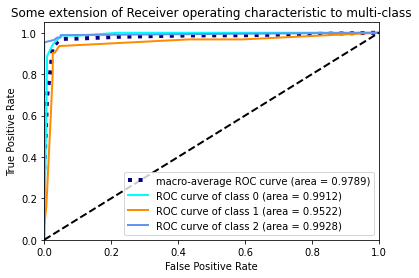

In [46]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): # 遍历三个类别
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], RFR3_pred[i, :])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), RFR3_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()


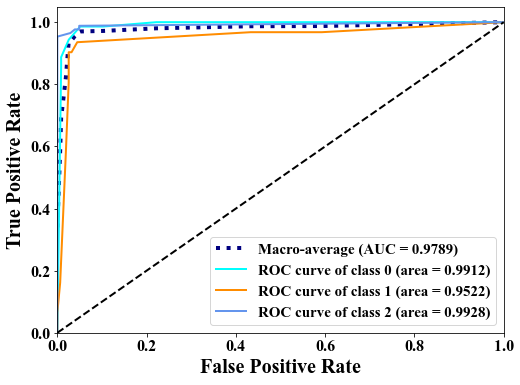

In [49]:
lw=2
# plt.figure()
plt.figure(plt.figure(figsize=(8, 6)))


plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (AUC = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.yticks(fontproperties='Times New Roman', size=16,weight='bold')#设置大小及加粗
plt.xticks(fontproperties='Times New Roman', size=16,weight='bold')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontproperties='Times New Roman', size=20,weight='bold')
plt.ylabel('True Positive Rate',fontproperties='Times New Roman', size=20,weight='bold')

font1 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 15}

plt.legend(loc="lower right",prop=font1)

plt.savefig("ODEL_RF_ROC.svg", dpi=300,format="svg")

plt.show()

<font color=#0099ff  size=10 face="黑体">方法2：DNN </font>

In [111]:
print(new_train.shape,y_train.shape,y_train_labels.shape,new_test1.shape,y_test.shape,y_test_label.shape)

(438, 9) (438,) (438, 3) (188, 9) (188,) (188, 3)


In [114]:
def buildDNN(layer1,layer2,n_class):
    init = K.initializers.glorot_uniform(seed=1)
    simple_adam = tf.keras.optimizers.Adam()
    model = K.models.Sequential()
    model.add(K.layers.Dense(units=layer1, input_dim=9, kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=layer2, kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=n_class, kernel_initializer=init, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])
    model.summary()
    return model

dnn = buildDNN(layer1=10,layer2=10,n_class=3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 10)                100       
                                                                 
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dense_15 (Dense)            (None, 3)                 33        
                                                                 
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


In [120]:
b_size = 35
max_epochs = 500
print("Starting training ")
dnn.fit(new_train, y_train_labels, batch_size=b_size, epochs=max_epochs, shuffle=True, verbose=1)

Starting training 
Train on 438 samples
Epoch 1/500
438/438 [==============================] - 0s 18us/sample - loss: 0.0162 - acc: 0.9909
Epoch 2/500
438/438 [==============================] - 0s 18us/sample - loss: 0.0155 - acc: 0.9932
Epoch 3/500
438/438 [==============================] - 0s 20us/sample - loss: 0.0153 - acc: 0.9932
Epoch 4/500
438/438 [==============================] - 0s 23us/sample - loss: 0.0149 - acc: 0.9932
Epoch 5/500
438/438 [==============================] - 0s 18us/sample - loss: 0.0154 - acc: 0.9932
Epoch 6/500
438/438 [==============================] - 0s 27us/sample - loss: 0.0158 - acc: 0.9932
Epoch 7/500
438/438 [==============================] - 0s 27us/sample - loss: 0.0159 - acc: 0.9932
Epoch 8/500
438/438 [==============================] - 0s 25us/sample - loss: 0.0151 - acc: 0.9932
Epoch 9/500
438/438 [==============================] - 0s 18us/sample - loss: 0.0159 - acc: 0.9932
Epoch 10/500
438/438 [==============================] - 0s 27us/sampl

In [121]:
dnn_test_proba = dnn.predict(new_test1)
dnn_test_pred =Predict(dnn_test_proba)

In [122]:
dnn_test_acc = accuracy_score(y_test, dnn_test_pred)
print("Dnn training with laryer  test score: {}".format(dnn_test_acc))

Dnn training with laryer  test score: 0.9148936170212766


In [123]:
print('ACC:', metrics.accuracy_score(y_test,dnn_test_pred))
 
print('macro-PRE:',metrics.precision_score(y_test,dnn_test_pred,average='macro')) 
 
print('macro-SEN:',metrics.recall_score(y_test, dnn_test_pred,average='macro'))
 
print('macroF1-score:',metrics.f1_score(y_test, dnn_test_pred,labels=[0,1,2],average='macro'))

ACC: 0.9148936170212766
macro-PRE: 0.8913117576779817
macro-SEN: 0.8918109809142426
macroF1-score: 0.8915356164931717


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9916\1718713388.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


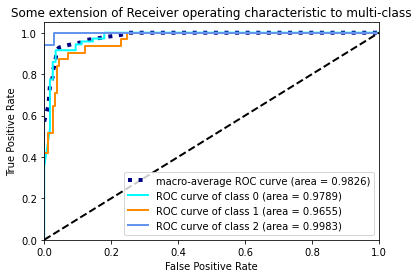

In [124]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): # 遍历三个类别
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], dnn_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), dnn_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<font color=#0099ff  size=10 face="黑体">方法3：DBN </font>

In [125]:
#DBN
dbn_cant_neuronas_capas_ocultas =  "10,10"
RBM_cant_epocas_entrenamiento = 35 
Backprop_cant_epocas_entrenamiento = 500 

# cantidad de neuronas ocultas 
hidden_layers = []
for val in dbn_cant_neuronas_capas_ocultas.split(','):
      hidden_layers.append( int(val))

dbn = SupervisedDBNClassification(hidden_layers_structure = hidden_layers,
                                                learning_rate_rbm=0.05,
                                                learning_rate=0.1,
                                                n_epochs_rbm=RBM_cant_epocas_entrenamiento,
                                                n_iter_backprop=Backprop_cant_epocas_entrenamiento,
                                                batch_size=32,
                                                activation_function='relu',
                                                dropout_p=0.2,
                                               )

In [126]:
dbn.fit(new_train, y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 1.843194
>> Epoch 2 finished 	RBM Reconstruction error 1.583123
>> Epoch 3 finished 	RBM Reconstruction error 1.370053
>> Epoch 4 finished 	RBM Reconstruction error 0.974814
>> Epoch 5 finished 	RBM Reconstruction error 0.681603
>> Epoch 6 finished 	RBM Reconstruction error 0.552442
>> Epoch 7 finished 	RBM Reconstruction error 0.490036
>> Epoch 8 finished 	RBM Reconstruction error 0.438852
>> Epoch 9 finished 	RBM Reconstruction error 0.383054
>> Epoch 10 finished 	RBM Reconstruction error 0.338256
>> Epoch 11 finished 	RBM Reconstruction error 0.316691
>> Epoch 12 finished 	RBM Reconstruction error 0.292734
>> Epoch 13 finished 	RBM Reconstruction error 0.277774
>> Epoch 14 finished 	RBM Reconstruction error 0.263041
>> Epoch 15 finished 	RBM Reconstruction error 0.248388
>> Epoch 16 finished 	RBM Reconstruction error 0.236441
>> Epoch 17 finished 	RBM Reconstruction error 0.227755
>> Epoch 18 finished 	RBM Reco

SupervisedDBNClassification(batch_size=32, dropout_p=0.2,
                            idx_to_label_map={0: 0, 1: 1, 2: 2},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 0, 1: 1, 2: 2},
                            learning_rate=0.1, n_iter_backprop=500,
                            verbose=True)

In [127]:
dbn_test_pred =dbn.predict(new_test1)
dbn_test_proba =dbn.predict_proba(new_test1)

In [128]:
print(np.isnan(dbn_test_pred ).any())

False


In [129]:
dbn_test_acc = accuracy_score(y_test, dbn_test_pred)
print("dbn training test score: {}".format(dbn_test_acc))

dbn training test score: 0.898936170212766


In [130]:
print('ACC:', metrics.accuracy_score(y_test,dbn_test_pred)) 
 
print('macro-PRE:',metrics.precision_score(y_test,dbn_test_pred,average='macro')) 
 
print('macro-SEN:',metrics.recall_score(y_test, dbn_test_pred,average='macro'))
 
print('macroF1-score:',metrics.f1_score(y_test, dbn_test_pred,labels=[0,1,2],average='macro'))

ACC: 0.898936170212766
macro-PRE: 0.872142449484074
macro-SEN: 0.8733063547577035
macroF1-score: 0.8724969448850685


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9916\1687146651.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


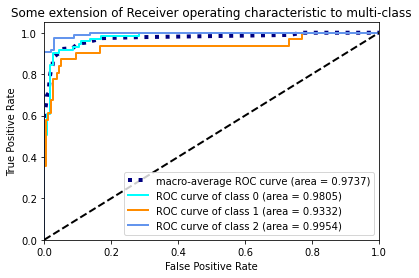

In [131]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): # 遍历三个类别
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], dbn_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), dbn_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
# plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.4f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

<font color=#0099ff  size=10 face="黑体">方法3：RNN </font>

In [132]:
def buildLSTM(timeStep,inputColNum,outStep,learnRate=1e-4):
    '''
    搭建LSTM网络，激活函数为tanh
    timeStep：输入时间步
    inputColNum：输入列数
    outStep：输出时间步
    learnRate：学习率    
    '''
    #输入层
    inputLayer = Input(shape=(timeStep,inputColNum))

    #中间层
    middle = LSTM(10,activation='tanh')(inputLayer)
    middle = Dense(10,activation='tanh')(middle)

    #输出层 全连接
    outputLayer = Dense(outStep)(middle)
    
    #建模
    model = Model(inputs=inputLayer,outputs=outputLayer)
    optimizer = Adam(learning_rate=learnRate)
    model.compile(optimizer=optimizer,loss='mse') 
    model.summary()
    return model

#搭建LSTM
lstm = buildLSTM(timeStep=1,inputColNum=9,outStep=3,learnRate=1e-4)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 9)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 10)                800       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 3)                 33        
                                                                 
Total params: 943
Trainable params: 943
Non-trainable params: 0
_________________________________________________________________


In [134]:
new_train_lstm = new_train.reshape(new_train.shape[0],1,new_train.shape[1])
new_test_lstm = new_test1.reshape(new_test1.shape[0],1,new_test1.shape[1])

In [135]:
epochs = 500 
batchSize = 35
lstm.fit(new_train_lstm,y_train_labels,epochs=epochs,verbose=1,batch_size=batchSize) 

Train on 438 samples
Epoch 1/500
438/438 [==============================] - 1s 2ms/sample - loss: 0.3411
Epoch 2/500
438/438 [==============================] - 0s 32us/sample - loss: 0.3353
Epoch 3/500
438/438 [==============================] - 0s 34us/sample - loss: 0.3296
Epoch 4/500
438/438 [==============================] - 0s 36us/sample - loss: 0.3240
Epoch 5/500
438/438 [==============================] - 0s 34us/sample - loss: 0.3186
Epoch 6/500
438/438 [==============================] - 0s 36us/sample - loss: 0.3133
Epoch 7/500
438/438 [==============================] - 0s 34us/sample - loss: 0.3081
Epoch 8/500
438/438 [==============================] - 0s 32us/sample - loss: 0.3030
Epoch 9/500
438/438 [==============================] - 0s 34us/sample - loss: 0.2980
Epoch 10/500
438/438 [==============================] - 0s 34us/sample - loss: 0.2931
Epoch 11/500
438/438 [==============================] - 0s 36us/sample - loss: 0.2883
Epoch 12/500
438/438 [=====================

In [136]:
LSTM_train_proba = lstm.predict(new_train_lstm)
LSTM_train_pred =Predict(LSTM_train_proba)
LSTM_test_proba = lstm.predict(new_test_lstm)
LSTM_test_pred =Predict(LSTM_test_proba)

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [137]:
LSTM_train_acc =  accuracy_score(y_train, LSTM_train_pred)
LSTM_test_acc = accuracy_score(y_test, LSTM_test_pred)
print("RNN training with laryer  train score: {}".format(LSTM_train_acc))
print("RNN training with laryer  test score: {}".format(LSTM_test_acc))

RNN training with laryer  train score: 0.9840182648401826
RNN training with laryer  test score: 0.898936170212766


In [138]:
print('ACC:', metrics.accuracy_score(y_test,LSTM_test_pred)) 
 
print('macro-PRE:',metrics.precision_score(y_test,LSTM_test_pred,average='macro')) 
 
print('macro-SEN:',metrics.recall_score(y_test, LSTM_test_pred,average='macro'))
 
print('macroF1-score:',metrics.f1_score(y_test, LSTM_test_pred,labels=[0,1,2],average='macro'))

ACC: 0.898936170212766
macro-PRE: 0.8774838330393885
macro-SEN: 0.8741252214462065
macroF1-score: 0.8749616407415562


C:\Users\Administrator\AppData\Local\Temp\ipykernel_9916\3893804580.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


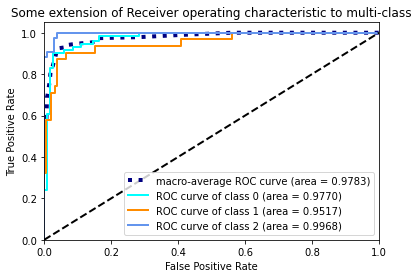

In [139]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes): # 遍历三个类别
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], LSTM_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), LSTM_test_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()